<a href="https://colab.research.google.com/github/lolo115/python-bazar/blob/master/notebooks/google_colab/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [0]:
!pip install geopandas 
!apt-get install imagemagick

In [0]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
from datetime import timedelta
from datetime import datetime

# Target Country Selection

In [3]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

rawdata_cases=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
rawdata_death=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

#GeoData

raw_cases=rawdata_cases.drop(columns=['Province/State'])
raw_death=rawdata_death.drop(columns=['Province/State'])

raw_cases_geo = gpd.GeoDataFrame(raw_cases, geometry=gpd.points_from_xy(raw_cases.Long, raw_cases.Lat))
raw_death_geo = gpd.GeoDataFrame(raw_death, geometry=gpd.points_from_xy(raw_death.Long, raw_death.Lat))

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

country=widgets.Dropdown(
    options=rawdata_cases['Country/Region'].unique(),
    value="France",
    description="Country",
    disabled=False
)

display(country)

Dropdown(description='Country', index=56, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', '…

# DataFrames creation

In [4]:
# Construction des datasets

raw_cases=rawdata_cases[rawdata_cases["Country/Region"]==country.value]
raw_cases=raw_cases.drop(columns=['Lat','Long','Province/State','Country/Region'])
r1=raw_cases.sum(axis=0).to_frame().reset_index()

r1.columns=['c_date','Nb_Cases']
r1=r1.drop(r1.index[0]) 
r1['c_date']=pd.to_datetime(r1['c_date'])


raw_death=rawdata_death[rawdata_death["Country/Region"]==country.value]
raw_death=raw_death.drop(columns=['Lat','Long','Province/State','Country/Region'])
r2=raw_death.sum(axis=0).to_frame().reset_index()

r2.columns=['d_date','Nb_deaths']
r2=r2.drop(r2.index[0]) 
r2['d_date']=pd.to_datetime(r2['d_date'])

r_final=r1.merge(r2, left_on=r1['c_date'], right_on=r2['d_date'])
r_final=r_final.drop(columns=['c_date','d_date'])
r_final.columns=['date','nb_cases','nb_deaths']
r_final.set_index('date', inplace=True)
del(r1)
del(r2)
#Filtre sur la date
r_final=r_final[r_final.index>='2020-03']
display(r_final.T)



date,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13
nb_cases,130,191,204,288,380,656,959,1136,1219,1794,2293,2293,3681,4496,4532,6683,7715,9124,10970,12758,14463,16243,20123,22622,25600,29551,33402,38105,40708,45170,52827,57749,59929,65202,69500,71412,75343,79163,83057,87366,91738,94863,121712,125394,130365,133585,146075,148084,148086,153011,155393,158168,155980,158303,159952,161644,162220,165963,169053,166543,167299,167305,168518,168925,169583,170687,174224,174918,176202,176782,177094,177547,178349,178184
nb_deaths,2,3,4,4,6,9,11,19,19,33,48,48,79,91,91,149,149,149,244,451,563,676,862,1102,1333,1698,1997,2317,2611,3030,3532,4414,5398,6520,7574,8093,8926,10343,10887,12228,13215,13851,14412,14986,15731,17169,17922,18683,19325,19720,20267,20798,21342,21858,22248,22617,22859,23296,23663,24090,24379,24597,24763,24900,25204,25537,25812,25990,26233,26313,26383,26646,26994,27077


# GeoData Plots and animation

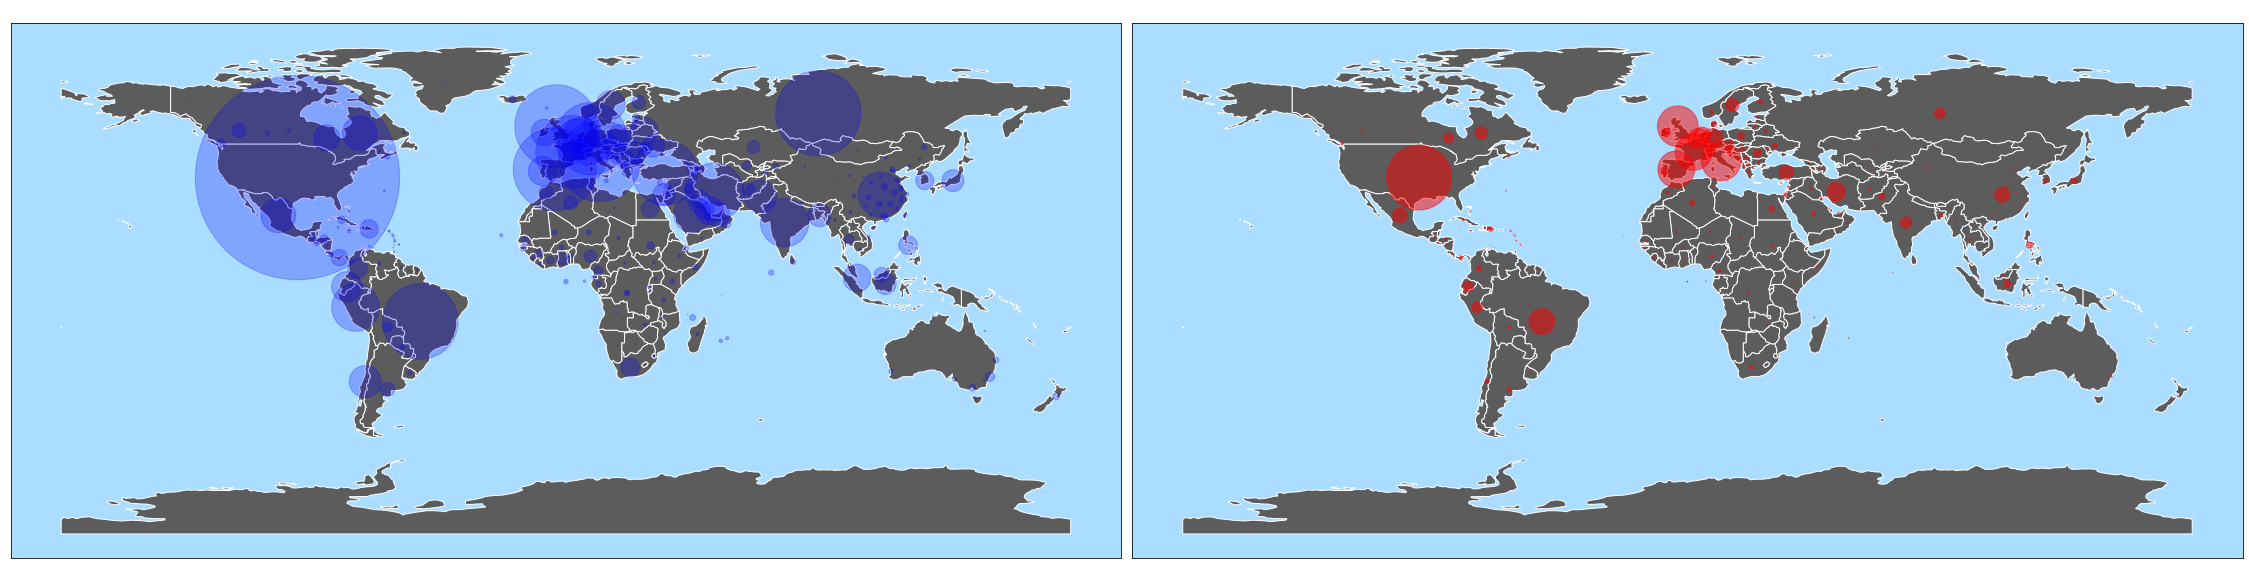

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(40,30))
plt.subplots_adjust(wspace=0.01)
yesterday = (datetime.now() - timedelta(days=1)).strftime("%-m/%-d/%y")

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax1.set_facecolor('#AADDFF')
ax1=world.plot(color='#5C5C5C',edgecolor='white',ax=ax1)
ax1.set_title(f"COVID19 cases on {yesterday}",color='white')
ax1.get_xaxis().set_visible(False); ax1.get_yaxis().set_visible(False)
raw_cases_geo.plot(ax=ax1,color='blue',markersize=raw_cases_geo[yesterday]*0.03, alpha=0.25)

ax2.set_facecolor('#AADDFF')
ax2=world.plot(color='#5C5C5C',edgecolor='white',ax=ax2)
ax2.set_title(f'COVID19 deaths on {yesterday}',color='white')
ax2.get_xaxis().set_visible(False); ax2.get_yaxis().set_visible(False)

raw_death_geo.plot(ax=ax2,color='red',markersize=raw_death_geo[yesterday]*0.05, alpha=0.5)

plt.show()


In [0]:
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib 

fig, ax1 = plt.subplots(figsize=(20,15))
plt.close()

yesterday = (datetime.now() - timedelta(days=1)).strftime("%-m/%-d/%y")

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax1.set_facecolor('#AADDFF')

#raw_cases_geo.plot(edgecolor='white',color='blue',markersize=raw_cases_geo[yesterday]*0.03, alpha=0.25 , ax=ax1)

plot_data=raw_cases_geo.iloc[:,3:len(raw_cases_geo.columns)-1]
# Column header type modification to timestamp
plot_data.columns=list(map(lambda x:datetime.strptime(x,"%m/%d/%y"), plot_data))
plot_data=plot_data[plot_data.columns]
# filtering by column date
plot_data.drop([col for col in plot_data.columns if col<datetime.strptime('20200301','%Y%m%d')],axis=1,inplace=True)

matplotlib.rcParams['animation.embed_limit'] = 50

# initialization function: plot the background of each frame
def init():
  return raw_cases_geo.plot(edgecolor='white',color='blue',markersize=plot_data.iloc[:,0]*0.03, alpha=0.25 , ax=ax1)  

# animation function. This is called sequentially  
def animate(i):
  ax1.clear()
  world.plot(color='#5C5C5C',edgecolor='white',ax=ax1)
  ax1.set_title(f"COVID19 Cases evolution. Date = {plot_data.columns[i]}")
  return raw_cases_geo.plot(edgecolor='white',color='blue',markersize=plot_data.iloc[:,i]*0.03, alpha=0.25 , ax=ax1)  
    
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(plot_data.columns), interval=200)
#anim.save('laurent.gif', writer = 'imagemagick')

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim


# Trend plots

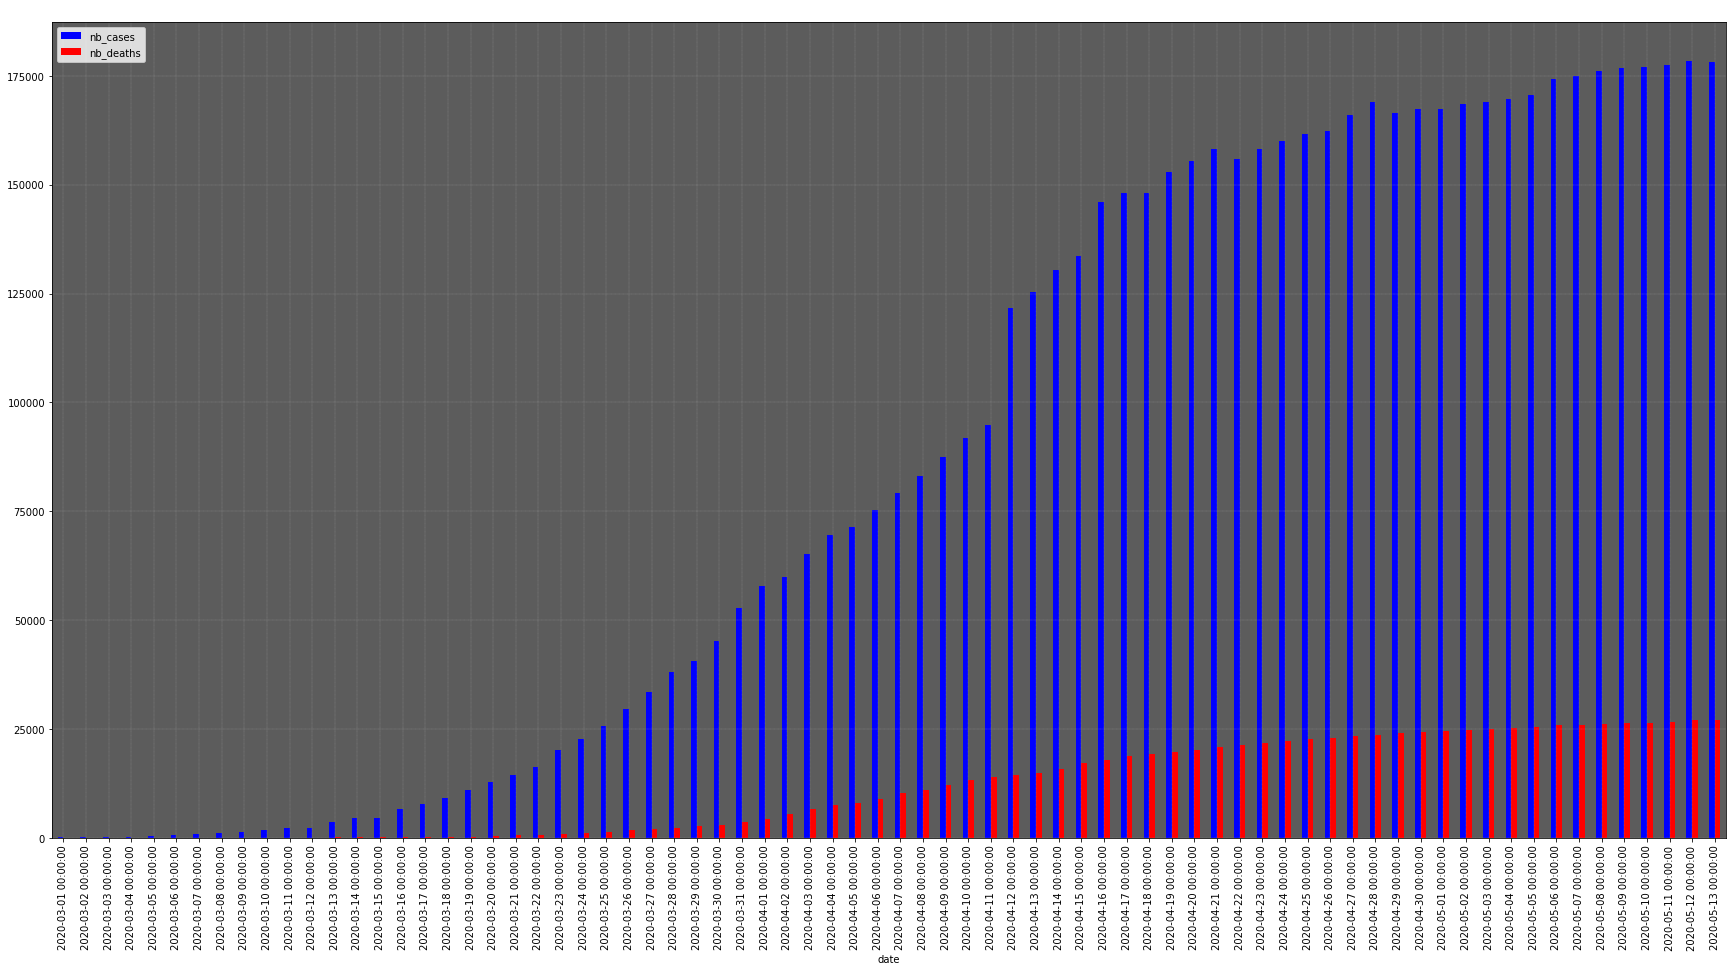

In [6]:
# Affichage
fig, ax = plt.subplots(figsize=(30,15))
#fig.autofmt_xdate()
ax.set_facecolor('#5C5C5C')
r_final.plot.bar(ax=ax, color=['b','r'])

ax.legend(loc="upper left")
ax.set_title(f"COVID Stats for - {country.value} ",color='w')
plt.grid(which='both',linestyle="--", linewidth=0.25)
plt.show()

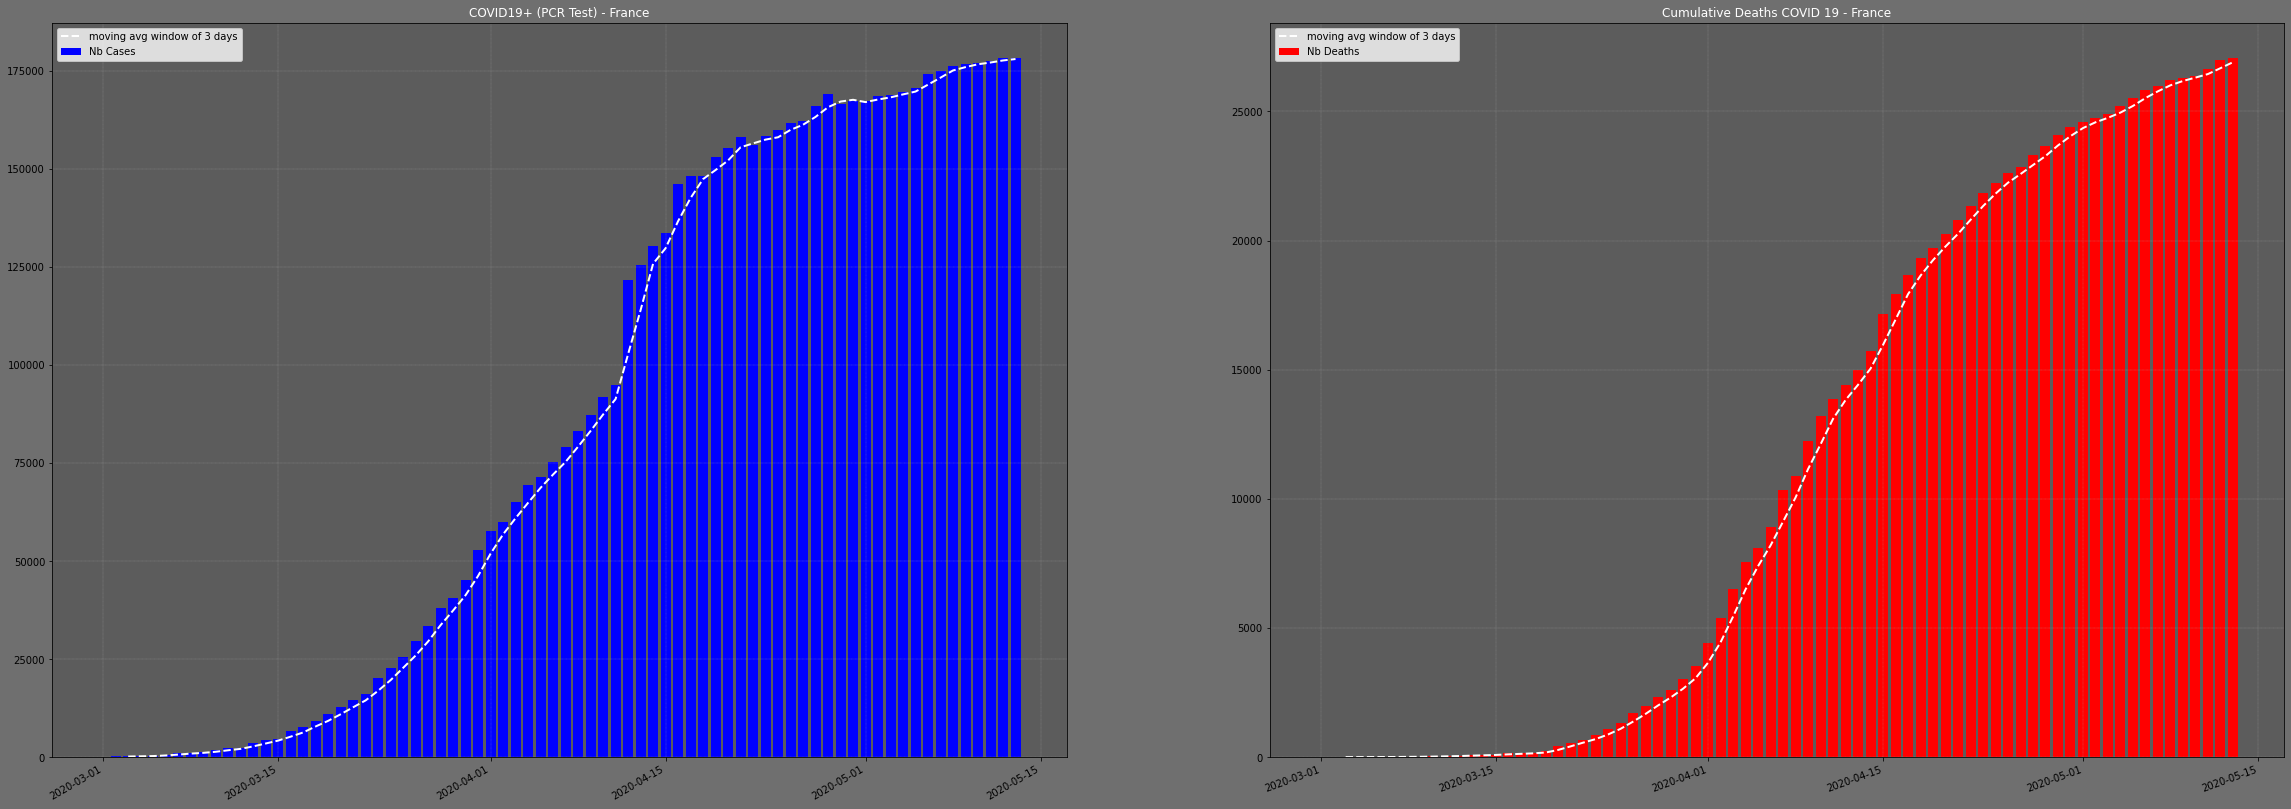

In [7]:
# Moving average

average_window_size=3

# Affichage
# fig, ax = plt.subplots(figsize=(30,15))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(40,15))
fig.autofmt_xdate()

fig.set_facecolor('#6F6F6F')
ax1.bar(r_final.index,r_final.nb_cases,color='blue',label="Nb Cases")
ax1.plot(r_final.index,r_final.nb_cases.rolling(window=average_window_size).mean(),color='white',ls='--',linewidth=2, label=f'moving avg window of {average_window_size} days')
ax1.set_facecolor('#5C5C5C')
ax1.legend(loc="upper left")
ax1.set_title(f"COVID19+ (PCR Test) - {country.value}",color='w')
ax1.grid(which='both',linestyle="--", linewidth=0.25)

ax2.bar(r_final.index,r_final.nb_deaths,color='red',label="Nb Deaths")
ax2.plot(r_final.index,r_final.nb_deaths.rolling(window=average_window_size).mean(),color='white',ls='--',linewidth=2, label=f'moving avg window of {average_window_size} days')
ax2.set_facecolor('#5C5C5C')
ax2.legend(loc="upper left")
ax2.set_title(f"Cumulative Deaths COVID 19 - {country.value}",color='w')
ax2.grid(which='both',linestyle="--", linewidth=0.25)

plt.xticks(rotation=20)
plt.show()

r_value = 0.9724430253870775 
p_value = 2.8317907036878866e-47 
std_err = 1.0391670459436654e-12
Equation : y=3.677881888738051e-11x+-58251259.00842647


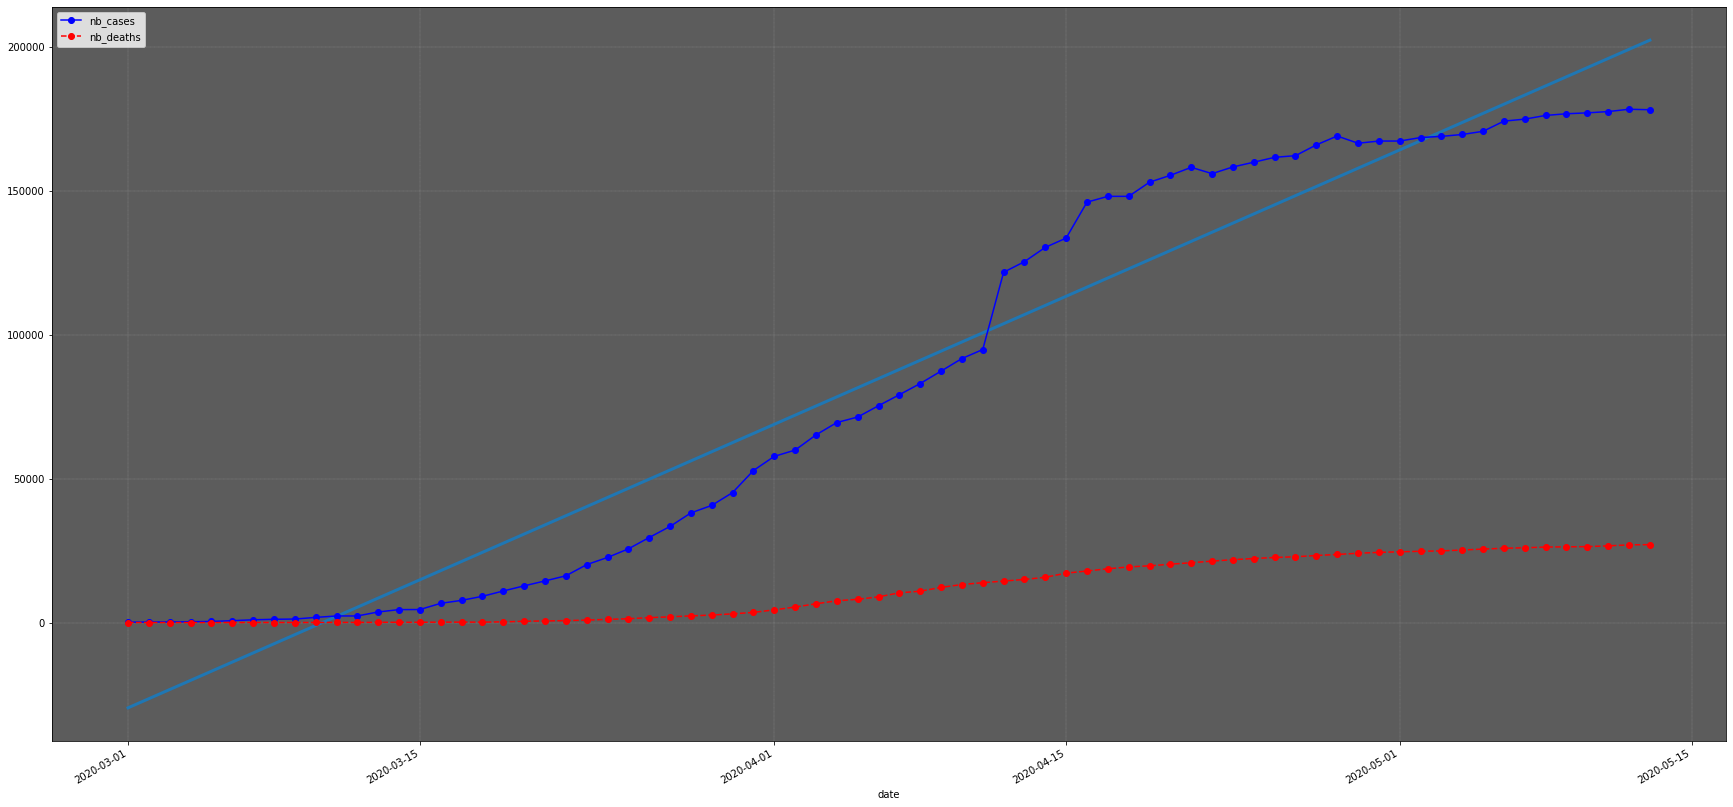

In [8]:
# Linear regression ... pour l'exemple, car pas grand intérêt pour une évolution épidémique !

import scipy.stats as sp

y=np.array(r_final['nb_cases'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(r_final.index.values), dtype=float)

slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),x.shape[0])
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print(f'r_value = {r_value} \np_value = {p_value} \nstd_err = {std_err}')
print(f'Equation : y={slope}x+{intercept}')
# Affichage
fig, ax = plt.subplots(figsize=(30,15))
ax.set_facecolor('#5C5C5C')

ax.plot(xf1,yf,lw=3)

r_final['nb_cases'].plot(marker='o',ls='-',color='blue',ax=ax)
r_final['nb_deaths'].plot(marker='o',ls='--',color='r',ax=ax)
ax.legend(loc="upper left")
plt.grid(which='both',linestyle="--", linewidth=0.25)
plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Regression polynom: 
              8              7             6             5             4
-7.226e-133 x + 1.686e-114 x + 1.436e-96 x - 1.745e-78 x - 5.708e-60 x
              3             2
 - 4.664e-42 x + 8.462e-24 x + 2.631e-05 x - 2.725e+13


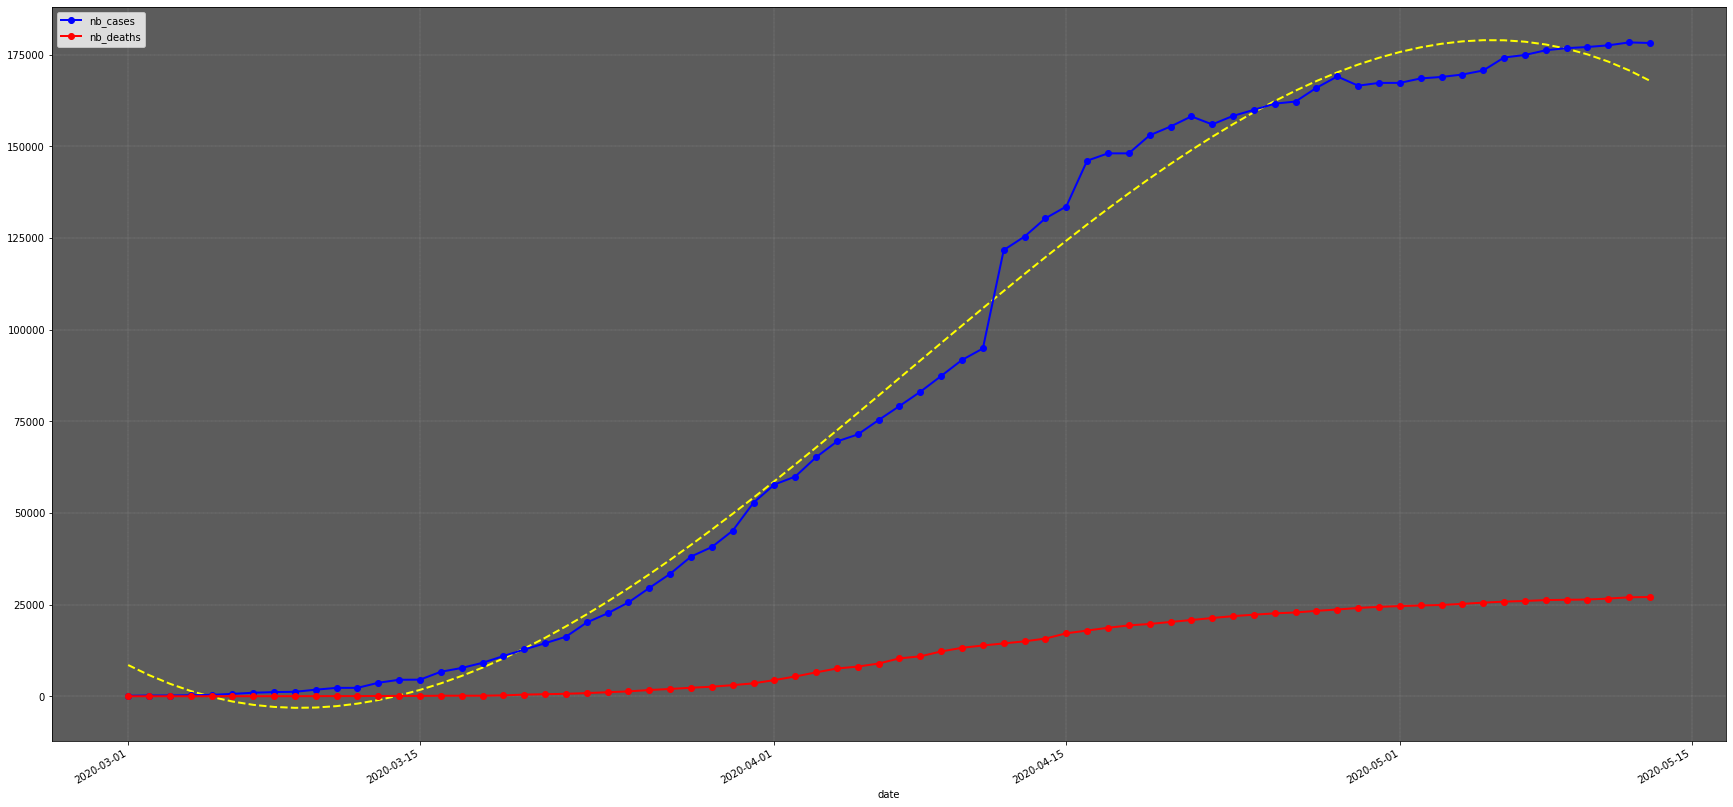

In [9]:
# Polynomial regression ... idem .. pas grand intérêt ! :)
# http://scipy-lectures.org/intro/numpy/auto_examples/plot_polyfit.html

y=np.array(r_final['nb_cases'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(r_final.index.values), dtype=float)

p = np.poly1d(np.polyfit(x, y, 8))
print("Regression polynom: \n",np.poly1d(p))

xf = np.linspace(min(x),max(x),x.shape[0])
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf=p(x)

# Affichage
fig, ax = plt.subplots(figsize=(30,15))
ax.set_facecolor('#5C5C5C')
ax.plot(xf1,yf,lw=2,color='yellow',linestyle='--')

r_final['nb_cases'].plot(marker='o',lw=2,color='blue',ax=ax)
r_final['nb_deaths'].plot(marker='o',lw=2,color='r',ax=ax)
ax.legend(loc="upper left")
plt.grid(which='both',linestyle="--", linewidth=0.25)
#plt.xticks(rotation=20)
plt.show()